# Imports

In [1]:
from pyabc import History

In [2]:
from experiments.ina_markov import (dias_iv_tau,
                                    nakajima_inactivation,
                                    #dias_inact_tau,
                                    zhang_recovery)

INFO:myokit:Loading Myokit version 1.28.3


In [3]:
from ionchannelABC.experiment import setup
from ionchannelABC import plot_sim_results

In [4]:
#modelfile = 'models/ina_simple.mmt'
modelfile = 'models/standardised_ina.mmt'
#modelfile = 'models/Korhonen2009_iNa.mmt'

## Activation only

In [5]:
observations, model, summary_statistics = setup(modelfile,
                                                dias_iv)
                                                #nakajima_inactivation,
                                                #zhang_recovery)

In [6]:
assert(len(observations)==len(summary_statistics(model({}))))

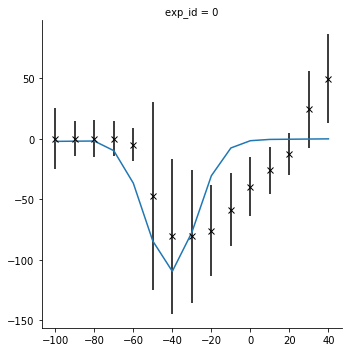

In [7]:
g = plot_sim_results(modelfile, 
                     dias_iv)
                     #nakajima_inactivation, zhang_recovery)

## Set limits and generate uniform initial priors

In [5]:
from pyabc import Distribution, RV
limits = {'ina.g_Na': (0., 200.),
          'ina.E_offset': (-100., 100.),
          'log_ina.p_1': (-7., 3.),
          'ina.p_2': (1e-7, 0.4),
          'log_ina.p_3': (-7., 3.),
          'ina.p_4': (1e-7, 0.4)}
          #'log_ina.p_5': (-7., 3.),
          #'ina.p_6': (1e-7, 0.4),
          #'log_ina.p_7': (-7., 3.),
          #'ina.p_8': (1e-7, 0.4),
          #'log_ina.A': (0., 2.)}
prior = Distribution(**{key: RV("uniform", a, b - a)
                        for key, (a,b) in limits.items()})

## Run ABC calibration

In [6]:
import os, tempfile
db_path = ("sqlite:///" +
           os.path.join(tempfile.gettempdir(), "hl1_ina.db"))
print(db_path)

sqlite:////scratch/cph211/tmp/hl1_ina.db


In [10]:
# Let's log all the sh!t
import logging
logging.basicConfig()
abc_logger = logging.getLogger('ABC')
abc_logger.setLevel(logging.DEBUG)
eps_logger = logging.getLogger('Epsilon')
eps_logger.setLevel(logging.DEBUG)

In [11]:
from pyabc.populationstrategy import AdaptivePopulationSize, ConstantPopulationSize
from ionchannelABC import theoretical_population_size
pop_size = theoretical_population_size(2, len(limits))
print("Theoretical minimum population size is {} particles".format(pop_size))

Theoretical minimum population size is 64 particles


In [12]:
from pyabc import ABCSMC
from pyabc.epsilon import MedianEpsilon
from pyabc.sampler import MulticoreEvalParallelSampler, SingleCoreSampler
from ionchannelABC import IonChannelDistance, EfficientMultivariateNormalTransition, IonChannelAcceptor

abc = ABCSMC(models=model,
             parameter_priors=prior,
             distance_function=IonChannelDistance(
                 exp_id=list(observations.exp_id),
                 variance=list(observations.variance),
                 delta=0.2),
             population_size=ConstantPopulationSize(500),
             summary_statistics=summary_statistics,
             transitions=EfficientMultivariateNormalTransition(),
             eps=MedianEpsilon(initial_epsilon=100),
             sampler=MulticoreEvalParallelSampler(n_procs=8),
             acceptor=IonChannelAcceptor())

DEBUG:ABC:ion channel weights: {'0': 0.9886046436297676, '1': 1.5414335269149804, '2': 1.5414335269149804, '3': 1.5414335269149804, '4': 1.5414335269149804, '5': 0.32127485731735844, '6': 0.38941897763367306, '7': 0.45089791005770086, '8': 0.6590167313800646, '9': 0.8290855652845911, '10': 1.027980077515453, '11': 1.285015418271755, '12': 1.4277866123989893, '13': 0.7787885836061572, '14': 0.6763965152445697}
DEBUG:Epsilon:init quantile_epsilon initial_epsilon=100, quantile_multiplier=1


In [13]:
obs = observations.to_dict()['y']
obs = {str(k): v for k, v in obs.items()}

In [14]:
abc_id = abc.new(db_path, obs)

INFO:History:Start <ABCSMC(id=8, start_time=2019-10-28 09:15:35.728825, end_time=None)>


In [ ]:
history = abc.run(minimum_epsilon=0., max_nr_populations=100, min_acceptance_rate=0.005)

INFO:ABC:t:0 eps:100
DEBUG:ABC:now submitting population 0
DEBUG:ABC:population 0 done
DEBUG:ABC:
total nr simulations up to t =0 is 532
DEBUG:Epsilon:new eps, t=1, eps=1.359454245709761
INFO:ABC:t:1 eps:1.359454245709761
DEBUG:ABC:now submitting population 1
DEBUG:ABC:population 1 done
DEBUG:ABC:
total nr simulations up to t =1 is 1529
DEBUG:Epsilon:new eps, t=2, eps=1.3594542456691419
INFO:ABC:t:2 eps:1.3594542456691419
DEBUG:ABC:now submitting population 2
DEBUG:ABC:population 2 done
DEBUG:ABC:
total nr simulations up to t =2 is 2791
DEBUG:Epsilon:new eps, t=3, eps=1.3594537358480114
INFO:ABC:t:3 eps:1.3594537358480114
DEBUG:ABC:now submitting population 3
DEBUG:ABC:population 3 done
DEBUG:ABC:
total nr simulations up to t =3 is 4320
DEBUG:Epsilon:new eps, t=4, eps=1.3583798885694371
INFO:ABC:t:4 eps:1.3583798885694371
DEBUG:ABC:now submitting population 4
DEBUG:ABC:population 4 done
DEBUG:ABC:
total nr simulations up to t =4 is 6518
DEBUG:Epsilon:new eps, t=5, eps=1.336831942153515

DEBUG:ABC:population 39 done
DEBUG:ABC:
total nr simulations up to t =39 is 255365
DEBUG:Epsilon:new eps, t=40, eps=0.14517944210522962
INFO:ABC:t:40 eps:0.14517944210522962
DEBUG:ABC:now submitting population 40
DEBUG:ABC:population 40 done
DEBUG:ABC:
total nr simulations up to t =40 is 261613
DEBUG:Epsilon:new eps, t=41, eps=0.14467129700653922
INFO:ABC:t:41 eps:0.14467129700653922
DEBUG:ABC:now submitting population 41
DEBUG:ABC:population 41 done
DEBUG:ABC:
total nr simulations up to t =41 is 266386
DEBUG:Epsilon:new eps, t=42, eps=0.14410319447304182
INFO:ABC:t:42 eps:0.14410319447304182
DEBUG:ABC:now submitting population 42
DEBUG:ABC:population 42 done
DEBUG:ABC:
total nr simulations up to t =42 is 269833
DEBUG:Epsilon:new eps, t=43, eps=0.1437276112786012
INFO:ABC:t:43 eps:0.1437276112786012
DEBUG:ABC:now submitting population 43
DEBUG:ABC:population 43 done
DEBUG:ABC:
total nr simulations up to t =43 is 271426
DEBUG:Epsilon:new eps, t=44, eps=0.1434447901999822
INFO:ABC:t:44 e

## Results analysis

In [7]:
history = History(db_path)
history.all_runs()

[<ABCSMC(id=1, start_time=2019-10-22 09:59:53.482889, end_time=2019-10-22 10:01:40.223258)>,
 <ABCSMC(id=2, start_time=2019-10-22 10:01:53.911852, end_time=2019-10-22 21:14:13.724435)>,
 <ABCSMC(id=3, start_time=2019-10-23 06:41:52.718919, end_time=2019-10-23 08:21:23.448172)>,
 <ABCSMC(id=4, start_time=2019-10-23 08:47:23.783832, end_time=2019-10-23 23:24:28.670063)>,
 <ABCSMC(id=5, start_time=2019-10-24 09:54:47.352669, end_time=2019-10-25 01:41:06.494668)>,
 <ABCSMC(id=6, start_time=2019-10-25 07:04:17.509290, end_time=2019-10-25 19:44:12.170429)>,
 <ABCSMC(id=7, start_time=2019-10-28 09:14:08.779688, end_time=None)>,
 <ABCSMC(id=8, start_time=2019-10-28 09:15:35.728825, end_time=None)>]

In [8]:
df, w = history.get_distribution(m=0)

In [9]:
df.describe()

name,ina.E_offset,ina.g_Na,ina.p_2,ina.p_4,log_ina.p_1,log_ina.p_3
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,44.321237,193.107404,0.104507,0.090176,1.702606,-2.480714
std,0.008785,0.305385,0.000010,0.000172,0.000326,0.004517
min,44.298760,192.338894,0.104478,0.089740,1.701882,-2.490541
25%,44.315257,192.877902,0.104500,0.090051,1.702369,-2.484139
50%,44.320621,193.125774,0.104507,0.090175,1.702591,-2.480860
75%,44.327642,193.328070,0.104515,0.090310,1.702838,-2.477377
max,44.345705,193.763010,0.104534,0.090568,1.703426,-2.469581


In [10]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

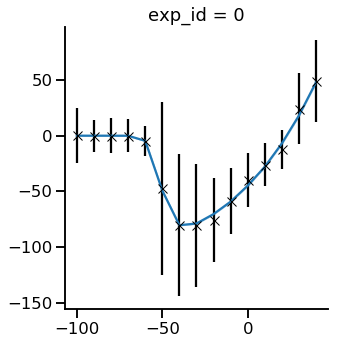

In [11]:
sns.set_context('talk')

mpl.rcParams['font.size'] = 14
mpl.rcParams['legend.fontsize'] = 14

g = plot_sim_results(modelfile, dias_iv, df=df, w=w)
    
plt.tight_layout()

## Inactivation only

In [5]:
observations, model, summary_statistics = setup(modelfile,
                                                #dias_iv_tau)
                                                nakajima_inactivation,
                                                dias_inact_tau,
                                                zhang_recovery)

In [6]:
assert(len(observations)==len(summary_statistics(model({}))))

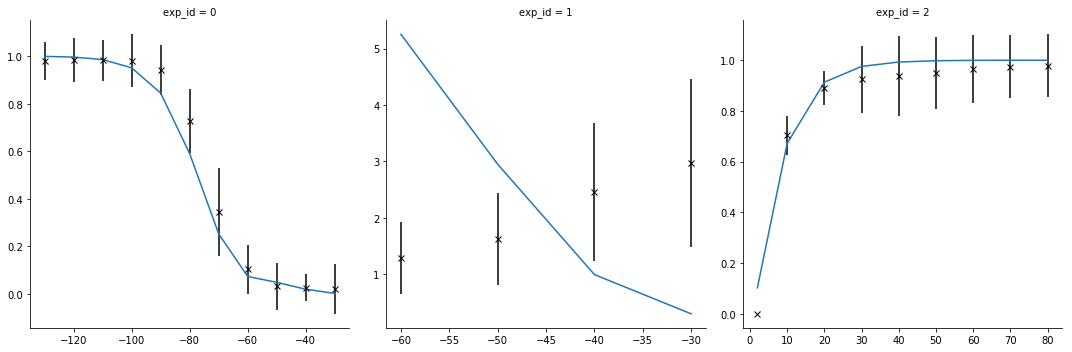

In [7]:
g = plot_sim_results(modelfile, 
                     #dias_iv_tau)
                     nakajima_inactivation,
                     dias_inact_tau,
                     zhang_recovery)

## Set limits and generate uniform initial priors

In [8]:
from pyabc import Distribution, RV
limits = {#'ina.g_Na': (0., 200.),
          #'ina.P_Na': (0., 1.),
          #'log_ina.p_1': (-7., 3.),
          #'ina.p_2': (1e-7, 0.4),
          #'log_ina.p_3': (-7., 3.),
          #'ina.p_4': (1e-7, 0.4)}
          'log_ina.p_5': (-7., 3.),
          'ina.p_6': (1e-7, 0.4),
          'log_ina.p_7': (-7., 3.),
          'ina.p_8': (1e-7, 0.4),
          'log_ina.A': (0., 2.)}
prior = Distribution(**{key: RV("uniform", a, b - a)
                        for key, (a,b) in limits.items()})

## Run ABC calibration

In [9]:
import os, tempfile
db_path = ("sqlite:///" +
           os.path.join(tempfile.gettempdir(), "hl1_ina.db"))
print(db_path)

sqlite:////scratch/cph211/tmp/hl1_ina.db


In [10]:
# Let's log all the sh!t
import logging
logging.basicConfig()
abc_logger = logging.getLogger('ABC')
abc_logger.setLevel(logging.DEBUG)
eps_logger = logging.getLogger('Epsilon')
eps_logger.setLevel(logging.DEBUG)

In [11]:
from pyabc.populationstrategy import AdaptivePopulationSize, ConstantPopulationSize
from ionchannelABC import theoretical_population_size
pop_size = theoretical_population_size(2, len(limits))
print("Theoretical minimum population size is {} particles".format(pop_size))

Theoretical minimum population size is 32 particles


In [12]:
from pyabc import ABCSMC
from pyabc.epsilon import MedianEpsilon
from pyabc.sampler import MulticoreEvalParallelSampler, SingleCoreSampler
from ionchannelABC import IonChannelDistance, EfficientMultivariateNormalTransition, IonChannelAcceptor

abc = ABCSMC(models=model,
             parameter_priors=prior,
             distance_function=IonChannelDistance(
                 exp_id=list(observations.exp_id),
                 variance=list(observations.variance),
                 delta=0.2),
             population_size=ConstantPopulationSize(500),
             summary_statistics=summary_statistics,
             transitions=EfficientMultivariateNormalTransition(),
             eps=MedianEpsilon(initial_epsilon=100),
             sampler=MulticoreEvalParallelSampler(n_procs=8),
             acceptor=IonChannelAcceptor())

DEBUG:ABC:ion channel weights: {'0': 0.8281689925178444, '1': 0.8281689925178444, '2': 0.8281689925178444, '3': 0.8281689925178444, '4': 0.8281689925178444, '5': 0.8281689925178444, '6': 0.8281689925178444, '7': 0.8281689925178444, '8': 0.8281689925178444, '9': 0.8281689925178444, '10': 0.8281689925178444, '11': 2.1020682769459373, '12': 1.6644067492388397, '13': 1.102821246653016, '14': 0.9109858917696287, '15': 1.0122065464106986, '16': 1.0122065464106986, '17': 1.0122065464106986, '18': 1.0122065464106986, '19': 1.0122065464106986, '20': 1.0122065464106986, '21': 1.0122065464106986, '22': 1.0122065464106986, '23': 1.0122065464106986}
DEBUG:Epsilon:init quantile_epsilon initial_epsilon=100, quantile_multiplier=1


In [13]:
obs = observations.to_dict()['y']
obs = {str(k): v for k, v in obs.items()}

In [14]:
abc_id = abc.new(db_path, obs)

INFO:History:Start <ABCSMC(id=12, start_time=2019-10-28 10:03:23.680514, end_time=None)>


In [ ]:
history = abc.run(minimum_epsilon=0., max_nr_populations=100, min_acceptance_rate=0.01)

INFO:ABC:t:0 eps:100
DEBUG:ABC:now submitting population 0


In [ ]:
history = abc.run(minimum_epsilon=0., max_nr_populations=100, min_acceptance_rate=0.01)

## Results analysis

In [17]:
history = History(db_path)
history.all_runs()

[<ABCSMC(id=1, start_time=2019-10-22 09:59:53.482889, end_time=2019-10-22 10:01:40.223258)>,
 <ABCSMC(id=2, start_time=2019-10-22 10:01:53.911852, end_time=2019-10-22 21:14:13.724435)>,
 <ABCSMC(id=3, start_time=2019-10-23 06:41:52.718919, end_time=2019-10-23 08:21:23.448172)>,
 <ABCSMC(id=4, start_time=2019-10-23 08:47:23.783832, end_time=2019-10-23 23:24:28.670063)>,
 <ABCSMC(id=5, start_time=2019-10-24 09:54:47.352669, end_time=2019-10-25 01:41:06.494668)>,
 <ABCSMC(id=6, start_time=2019-10-25 07:04:17.509290, end_time=2019-10-25 19:44:12.170429)>,
 <ABCSMC(id=7, start_time=2019-10-28 09:14:08.779688, end_time=None)>,
 <ABCSMC(id=8, start_time=2019-10-28 09:15:35.728825, end_time=None)>,
 <ABCSMC(id=9, start_time=2019-10-28 09:54:33.081848, end_time=None)>,
 <ABCSMC(id=10, start_time=2019-10-28 09:55:50.551530, end_time=None)>,
 <ABCSMC(id=11, start_time=2019-10-28 10:02:37.269457, end_time=None)>,
 <ABCSMC(id=12, start_time=2019-10-28 10:03:23.680514, end_time=2019-10-28 19:45:30.2

In [18]:
df, w = history.get_distribution(m=0)

In [19]:
df.describe()

name,ina.p_6,ina.p_8,log_ina.A,log_ina.p_5,log_ina.p_7
count,500.000000,500.000000,500.000000,500.000000,500.000000
mean,0.002874,0.150172,1.421638,1.298731,-3.335705
std,0.002204,0.020109,0.680863,0.708555,0.634970
min,0.000020,0.094529,0.000415,-0.197956,-5.429808
25%,0.001173,0.135418,1.521295,1.386717,-3.722034
50%,0.002388,0.149990,1.710800,1.593734,-3.225525
75%,0.004080,0.162429,1.835564,1.727690,-2.893001
max,0.010367,0.219479,1.997598,1.988840,-1.857629


In [20]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

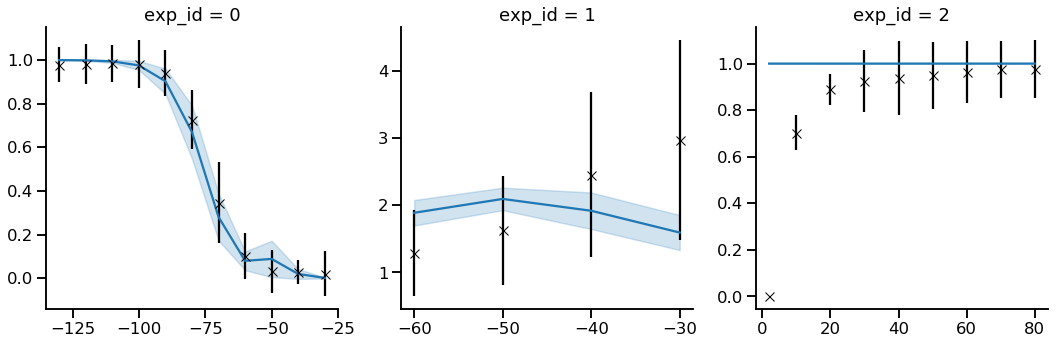

In [21]:
sns.set_context('talk')

mpl.rcParams['font.size'] = 14
mpl.rcParams['legend.fontsize'] = 14

g = plot_sim_results(modelfile, nakajima_inactivation, dias_inact_tau, zhang_recovery, df=df, w=w)

#xlabels = ["voltage, mV"]*3
#ylabels = ["current density, pA/pF", "relative inactivation", "relative recovery"]
#titles = ["IV curve", "Inactivation", "Recovery"]
#for ax, xl in zip(g.axes.flatten(), xlabels):
#    ax.set_xlabel(xl)
#for ax, yl in zip(g.axes.flatten(), ylabels):
#    ax.set_ylabel(yl)
#for ax, t in zip(g.axes.flatten(), titles):
#    ax.set_title(t)
    
plt.tight_layout()

## Full calibration

In [5]:
observations, model, summary_statistics = setup(modelfile,
                                                dias_iv_tau,
                                                nakajima_inactivation,
                                                #dias_inact_tau,
                                                zhang_recovery)

In [6]:
assert(len(observations)==len(summary_statistics(model({}))))

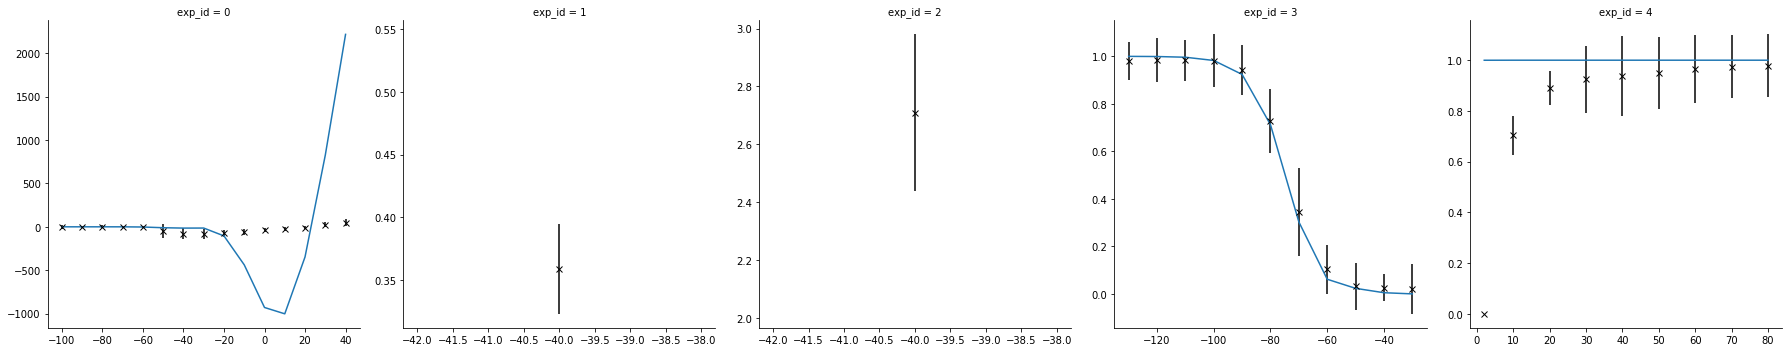

In [7]:
g = plot_sim_results(modelfile, 
                     dias_iv_tau,
                     nakajima_inactivation,
                     #dias_inact_tau,
                     zhang_recovery)

## Set limits and generate uniform initial priors

In [8]:
from pyabc import Distribution, RV
limits = {'log_ina.g_Na': (0., 2.),
          'log_ina.p_1': (1., 5.),
          'ina.p_2': (1e-7, 0.4),
          'log_ina.p_3': (-3., 1.),
          'ina.p_4': (1e-7, 0.4),
          'log_ina.p_5': (0., 3.),
          'ina.p_6': (1e-7, 0.4),
          'log_ina.p_7': (-4., -1.),
          'ina.p_8': (1e-7, 0.4),
          'log_ina.A': (0., 2.)}
prior = Distribution(**{key: RV("uniform", a, b - a)
                        for key, (a,b) in limits.items()})

## Run ABC calibration

In [9]:
import os, tempfile
db_path = ("sqlite:///" +
           os.path.join(tempfile.gettempdir(), "hl1_ina.db"))
print(db_path)

sqlite:////scratch/cph211/tmp/hl1_ina.db


In [32]:
# Let's log all the sh!t
import logging
logging.basicConfig()
abc_logger = logging.getLogger('ABC')
abc_logger.setLevel(logging.DEBUG)
eps_logger = logging.getLogger('Epsilon')
eps_logger.setLevel(logging.DEBUG)

In [33]:
from pyabc.populationstrategy import AdaptivePopulationSize, ConstantPopulationSize
from ionchannelABC import theoretical_population_size
pop_size = theoretical_population_size(2, len(limits))
print("Theoretical minimum population size is {} particles".format(pop_size))

Theoretical minimum population size is 1024 particles


In [34]:
from pyabc import ABCSMC
from pyabc.epsilon import MedianEpsilon
from pyabc.sampler import MulticoreEvalParallelSampler, SingleCoreSampler
from ionchannelABC import IonChannelDistance, EfficientMultivariateNormalTransition, IonChannelAcceptor

abc = ABCSMC(models=model,
             parameter_priors=prior,
             distance_function=IonChannelDistance(
                 exp_id=list(observations.exp_id),
                 variance=list(observations.variance),
                 delta=0.2),
             population_size=ConstantPopulationSize(2000),
             summary_statistics=summary_statistics,
             transitions=EfficientMultivariateNormalTransition(),
             eps=MedianEpsilon(initial_epsilon=100),
             sampler=MulticoreEvalParallelSampler(n_procs=8),
             acceptor=IonChannelAcceptor())

DEBUG:ABC:ion channel weights: {'0': 0.3403082062934336, '1': 0.530608956821213, '2': 0.530608956821213, '3': 0.530608956821213, '4': 0.530608956821213, '5': 0.11059271380662668, '6': 0.13405002154204695, '7': 0.15521296605466783, '8': 0.22685388260961878, '9': 0.2853968200572602, '10': 0.35386244495092617, '11': 0.44234193605025846, '12': 0.4914881840442202, '13': 0.2680830478357212, '14': 0.23283654019757186, '15': 7.959134352318196, '16': 7.959134352318196, '17': 0.7235576683925633, '18': 0.7235576683925633, '19': 0.7235576683925633, '20': 0.7235576683925633, '21': 0.7235576683925633, '22': 0.7235576683925633, '23': 0.7235576683925633, '24': 0.7235576683925633, '25': 0.7235576683925633, '26': 0.7235576683925633, '27': 0.7235576683925633, '28': 0.8843482613686885, '29': 0.8843482613686885, '30': 0.8843482613686885, '31': 0.8843482613686885, '32': 0.8843482613686885, '33': 0.8843482613686885, '34': 0.8843482613686885, '35': 0.8843482613686885, '36': 0.8843482613686885}
DEBUG:Epsilon:i

In [35]:
obs = observations.to_dict()['y']
obs = {str(k): v for k, v in obs.items()}

In [36]:
abc_id = abc.new(db_path, obs)

INFO:History:Start <ABCSMC(id=4, start_time=2019-11-22 09:30:43.208917, end_time=None)>


In [ ]:
history = abc.run(minimum_epsilon=0., max_nr_populations=100, min_acceptance_rate=0.01)

INFO:ABC:t:0 eps:100
DEBUG:ABC:now submitting population 0


In [ ]:
history = abc.run(minimum_epsilon=0., max_nr_populations=100, min_acceptance_rate=0.005)

In [ ]:
history = abc.run(minimum_epsilon=0., max_nr_populations=100, min_acceptance_rate=0.0025)

INFO:ABC:t:21 eps:0.5816833775485223
DEBUG:ABC:now submitting population 21


In [ ]:
history = abc.run(minimum_epsilon=0., max_nr_populations=100, min_acceptance_rate=0.001)

## Results analysis

In [10]:
history = History(db_path)
history.all_runs()

[<ABCSMC(id=1, start_time=2019-11-20 11:13:52.562260, end_time=2019-11-20 11:14:23.132930)>,
 <ABCSMC(id=2, start_time=2019-11-20 11:14:48.942998, end_time=2019-11-20 14:55:05.872376)>,
 <ABCSMC(id=3, start_time=2019-11-21 09:52:57.621107, end_time=2019-11-22 06:51:22.099131)>,
 <ABCSMC(id=4, start_time=2019-11-22 09:30:43.208917, end_time=2019-11-23 14:45:59.674084)>]

In [11]:
df, w = history.get_distribution(m=0)

In [12]:
df.describe()

name,ina.p_2,ina.p_4,ina.p_6,ina.p_8,log_ina.A,log_ina.g_Na,log_ina.p_1,log_ina.p_3,log_ina.p_5,log_ina.p_7
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,0.196777,0.080062,0.088468,0.043631,0.515440,0.486203,3.308393,-1.637185,1.088905,-2.708749
std,0.065629,0.044506,0.018286,0.014377,0.277675,0.210334,0.959654,0.793237,0.305986,0.709566
min,0.056337,0.000087,0.045453,0.001187,0.000472,0.013000,1.012411,-2.999076,0.253900,-3.999840
25%,0.146853,0.044328,0.075003,0.033011,0.292536,0.350838,2.578631,-2.296902,0.873699,-3.299839
50%,0.197073,0.076044,0.086698,0.043969,0.510800,0.469688,3.366894,-1.694064,1.057943,-2.716324
75%,0.241755,0.113622,0.100692,0.055208,0.723275,0.584492,4.096329,-1.034200,1.271517,-2.154374
max,0.399765,0.187999,0.149896,0.078648,1.575794,1.767269,4.997905,0.308052,2.440695,-1.005406


In [13]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

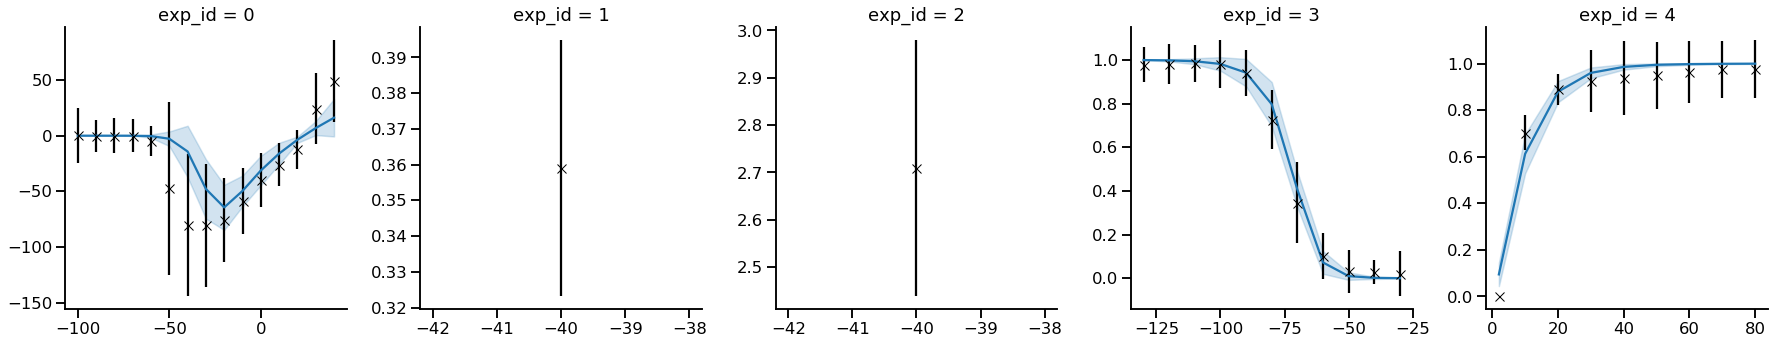

In [20]:
sns.set_context('talk')

mpl.rcParams['font.size'] = 14
mpl.rcParams['legend.fontsize'] = 14

g = plot_sim_results(modelfile, dias_iv_tau, nakajima_inactivation, zhang_recovery, df=df, w=w)

#xlabels = ["voltage, mV"]*3
#ylabels = ["current density, pA/pF", "relative inactivation", "relative recovery"]
#titles = ["IV curve", "Inactivation", "Recovery"]
#for ax, xl in zip(g.axes.flatten(), xlabels):
#    ax.set_xlabel(xl)
#for ax, yl in zip(g.axes.flatten(), ylabels):
#    ax.set_ylabel(yl)
#for ax, t in zip(g.axes.flatten(), titles):
#    ax.set_title(t)
    
plt.tight_layout()

In [21]:
g.savefig('/storage/hhecm/cellrotor/chouston/abc-hl1-results/ina/calibrated.pdf')

In [15]:
from ionchannelABC.visualization import plot_experiment_traces

In [16]:
def split_iv(data):
    out = []
    for d in data.split_periodic(5100, adjust=True):
        d = d.trim(4950, 5100, adjust=True)
        out.append(d)
    return out
def split_inact(data):
    out = []
    for d in data.split_periodic(5600, adjust=True):
        d = d.trim(5450, 5600, adjust=True)
        out.append(d)
    return out

In [17]:
import data.ina.data_ina as data
times_rec, _, _ = data.Recovery_Zhang()
split_times = [3040+tw for tw in times_rec]
for i, time in enumerate(split_times[:-1]):
    split_times[i+1] += split_times[i]
    
def split_rec(data):
    out = []
    for i, time in enumerate(split_times):
        d_, data = data.split(time)
        out.append(
            d_.trim(d_['engine.time'][0]+3000,
                    d_['engine.time'][0]+3040+times_rec[i],
                    adjust=True)
        )
    return out

In [18]:
from experiments.ina_markov import dias_iv

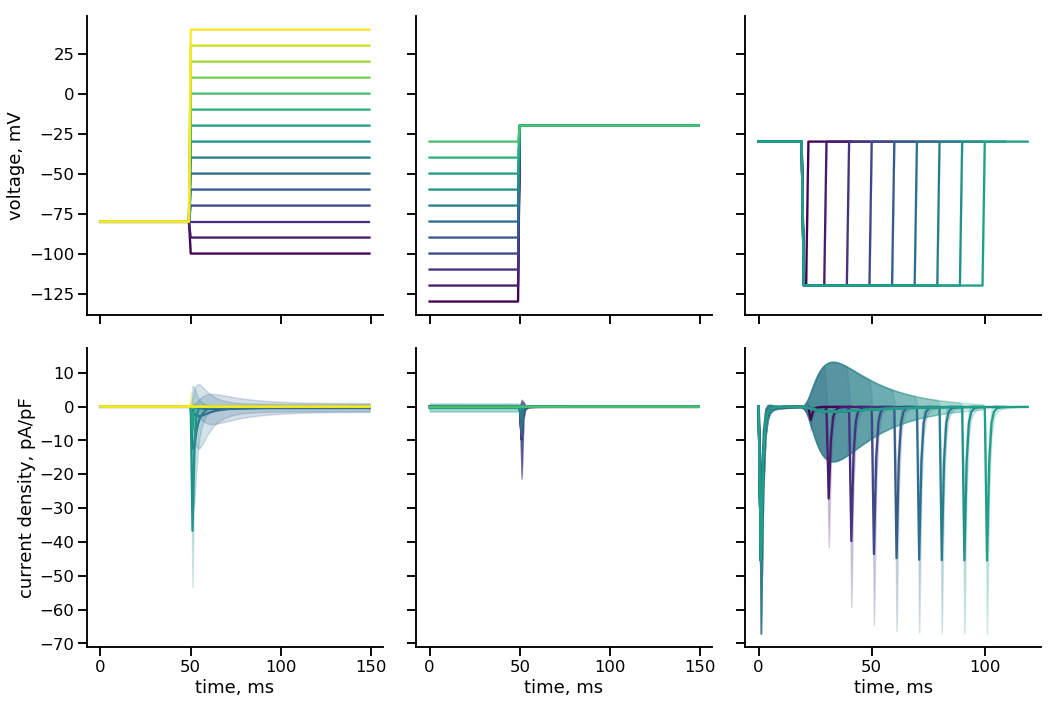

In [22]:
sns.set_context('talk')

mpl.rcParams['font.size'] = 14
mpl.rcParams['legend.fontsize'] = 14

g = plot_experiment_traces(modelfile, 'ina.i_Na', [split_iv, split_inact, split_rec],
                           dias_iv, nakajima_inactivation, zhang_recovery, df=df, w=w, 
                           log_interval=1)

xlabel = "time, ms"
ylabels = ["voltage, mV", "current density, pA/pF"]
for ax in g.axes[1,:]:
    ax.set_xlabel(xlabel)
for ax, yl in zip(g.axes, ylabels):
    ax[0].set_ylabel(yl)
for ax in g.axes.flatten():
    ax.set_title('')
    
plt.tight_layout()

In [23]:
g.savefig('/storage/hhecm/cellrotor/chouston/abc-hl1-results/ina/protocol.pdf')

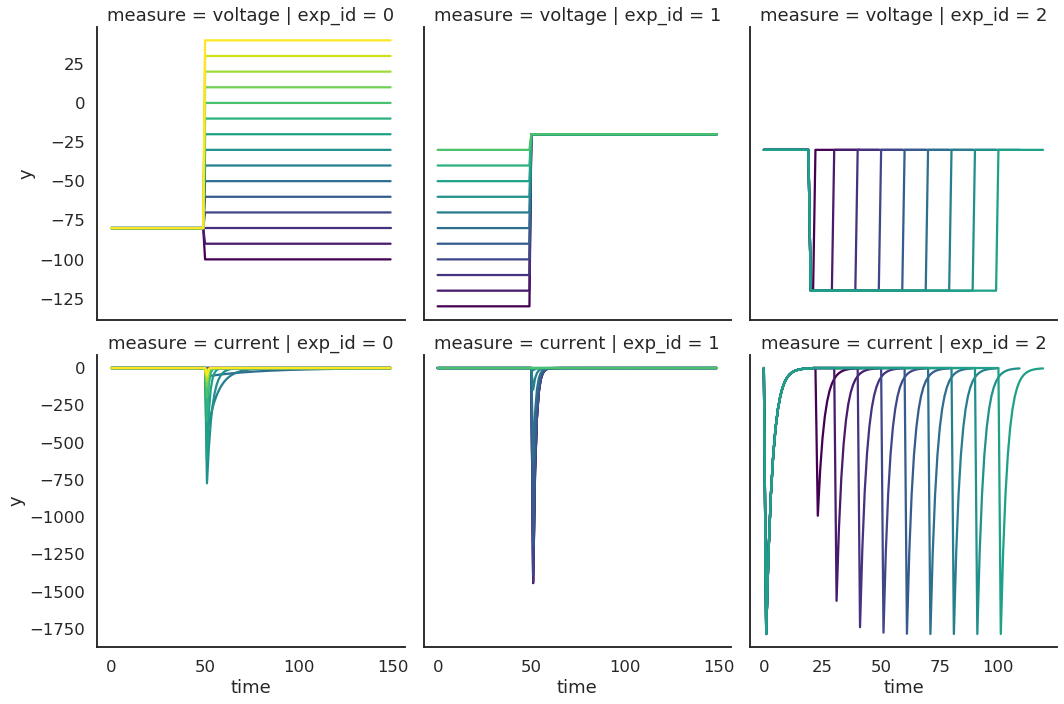

In [45]:
g = plot_experiment_traces('models/Korhonen2009_iNa.mmt', 'ina.i_Na', [split_iv, split_inact, split_rec],
                           dias_iv_tau, nakajima_inactivation, zhang_recovery,
                           log_interval=1)

In [20]:
# Generate parameter samples
n_samples = 100
df, w = history.get_distribution(m=0)
th_samples = df.sample(n=n_samples, weights=w, replace=True).to_dict(orient='records')

In [22]:
# Generate sim results samples
import pandas as pd
samples = pd.DataFrame({})
for i, th in enumerate(th_samples):
    results = summary_statistics(model(th))
    output = pd.DataFrame({'x': observations.x, 'y': list(results.values()),
                           'exp_id': observations.exp_id})
    #output = model.sample(pars=th, n_x=50)
    output['sample'] = i
    output['distribution'] = 'post'
    samples = samples.append(output, ignore_index=True)

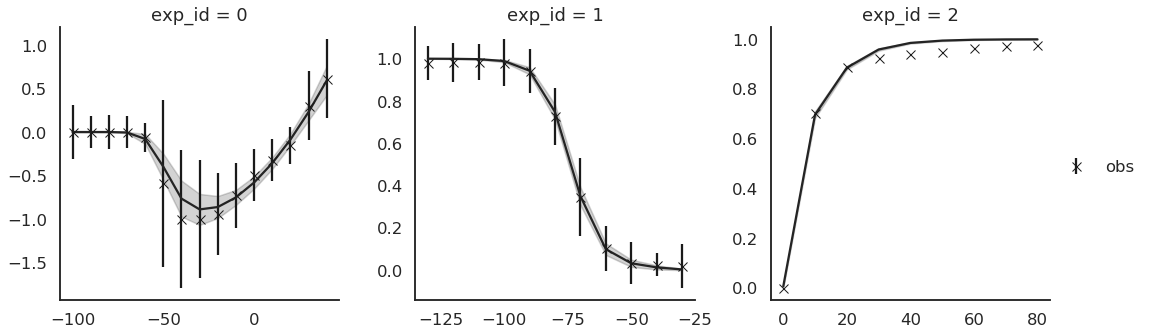

In [23]:
from ionchannelABC import plot_sim_results
import seaborn as sns
sns.set_context('talk')
g = plot_sim_results(samples, obs=observations)

In [113]:
# Require discrete samples for exact measurements at -20mV
discrete_samples = pd.DataFrame({})
for i, th in enumerate(th_samples):
    output = model.sample(pars=th)
    output['sample'] = i
    output['distribution'] = 'post'
    discrete_samples = discrete_samples.append(output, ignore_index=True)

In [114]:
# Amplitude at -20 mV
grouped = discrete_samples[discrete_samples['exp']==0].groupby('sample')
def get_amplitude(group):
    return group.loc[group.x==-20]['y']
print(grouped.apply(get_amplitude).mean())
print(grouped.apply(get_amplitude).std())

-163.74165119888335
0.14129370301730562


In [115]:
import scipy.stats as st
peak_current = discrete_samples[discrete_samples['exp']==0].groupby('sample').apply(get_amplitude).tolist()
rv = st.rv_discrete(values=(peak_current, [1/len(peak_current),]*len(peak_current)))
print("median: {}".format(rv.median()))
print("95% CI: {}".format(rv.interval(0.95)))

median: -163.81705987307208
95% CI: (-163.85178097293564, -163.4658692841079)


In [116]:
# Voltage and slope factor at half-activation
from scipy.optimize import curve_fit
grouped = samples[samples['exp']==1].groupby('sample')
def fit_boltzmann(group):
    def boltzmann(V, Vhalf, Shalf):
        return 1/(1+np.exp((Vhalf-V)/Shalf))
    guess = (-50, 10)
    popt, _ = curve_fit(boltzmann, group.x, group.y, guess)
    return popt
output = grouped.apply(fit_boltzmann).apply(pd.Series)

In [117]:
print(output.mean())
print(output.std())

0   -34.955683
1     7.200565
dtype: float64
0    0.015053
1    0.010894
dtype: float64


In [118]:
Vhalf = output[0].tolist()
rv = st.rv_discrete(values=(Vhalf, [1/len(Vhalf),]*len(Vhalf)))
print("median: {}".format(rv.median()))
print("95% CI: {}".format(rv.interval(0.95)))

median: -34.96014346870338
95% CI: (-34.97005619255574, -34.926599614270145)


In [119]:
slope = output[1].tolist()
rv = st.rv_discrete(values=(slope, [1/len(slope),]*len(slope)))
print("median: {}".format(rv.median()))
print("95% CI: {}".format(rv.interval(0.95)))

median: 7.197369620500938
95% CI: (7.19090481887031, 7.224585984649747)


In [120]:
# Voltage and slope factor at half-inactivation
grouped = samples[samples['exp']==2].groupby('sample')
def fit_boltzmann(group):
    def boltzmann(V, Vhalf, Shalf):
        return 1/(1+np.exp((V-Vhalf)/Shalf))
    guess = (-50, 10)
    popt, _ = curve_fit(boltzmann, group.x, group.y, guess)
    return popt
output = grouped.apply(fit_boltzmann).apply(pd.Series)

In [121]:
print(output.mean())
print(output.std())

0   -72.193234
1     6.109548
dtype: float64
0    0.125658
1    0.078064
dtype: float64


In [122]:
Vhalf = output[0].tolist()
rv = st.rv_discrete(values=(Vhalf, [1/len(Vhalf),]*len(Vhalf)))
print("median: {}".format(rv.median()))
print("95% CI: {}".format(rv.interval(0.95)))

median: -72.21669685772069
95% CI: (-72.44020974010718, -71.87864783039117)


In [123]:
slope = output[1].tolist()
rv = st.rv_discrete(values=(slope, [1/len(slope),]*len(slope)))
print("median: {}".format(rv.median()))
print("95% CI: {}".format(rv.interval(0.95)))

median: 6.154343522380662
95% CI: (5.931996934878577, 6.207057392589782)
